# Library

In [1]:
!pip install -Uq diffusers ftfy accelerate

In [54]:
import numpy as np
import requests
from io import BytesIO
from PIL import Image
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from huggingface_hub import notebook_login

import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from datasets import load_dataset
from diffusers import (
    UNet2DModel,
    DDIMScheduler,
    DDPMScheduler,
    DDPMPipeline,
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline,
)

# Stable Diffusion

paper: [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752)

<br>

이미지를 생성하는 딥러닝 기반 모델. <br>
이 모델은 딥러닝의 **GAN**과 확산 모델의 기술을 결합하여 이미지의 세밀함과 현실감을 높힘. <br>
기본적으로 입력된 텍스트를 토대로, 그 의미와 관련 있는 이미지를 점진적으로 생성해 가는 방식으로 작동.


Auto Encoder 모델을 계층화하였으며, 이미지 합성 분야에서 획기적인 결과. <br>
diffusion model은 다른 생성 모델들과 다르게 쉽게 다른 분야 (inpainting, 색상 추가-colorization)에 적용 가능. <br>


## Diffusion Model

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FvwAn1%2FbtrNwkjFAn3%2FAvT141LiMsckI2XpEZtYSK%2Fimg.png" width=600>

<br>

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FETLeE%2Fbtr6bu1KNlU%2FoRi4IGQcMyXOA1Bcc2HUSK%2Fimg.png" width=600>

<br>

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FnNaWO%2Fbtr6ANOKwPu%2F6fkAIJ9hUMKckICCqr46XK%2Fimg.png" width=600>

data에 noise를 조금씩 더해가거나 noise로부터 조금씩 복원해가는 과정을 통해 data를 생성하는 모델. <br>
- $q(x_t|x_{t-1})$: 오른쪽에서 왼쪽 방향으로 noise를 점점 더해가는 forward process
- $p_{\theta}(x_{t-1}|x_{t})$: forward process를 반대로 추정하는 reverse process <br>
    noise로부터 원본 이미지를 복원



## 기존의 문제

1\. 기존 diffusion model은 연산량이 많음. <br>
2\. GAN의 적대적 학습은 복잡한 multi-modal 분포를 모델링 하는데 어렵기 때문에 제한된 사용처밖에 사용할 수 없음.

## Contribution

1. 순수 Transformer 기반 접근 방식과 달리, 고차원 데이터에 대해 보다 효율적이고 세밀한 재구성을 제공.
-> 이를 통해 메가픽셀 수준의 고해상도 이미지 생성이 가능하며, 압축 단계에서 중요한 정보만 유지해 불필요한 계산을 줄임.

2. unconditional image synthesis, inpainting, stochastic super-resolution 등 다양한 작업과 데이터셋에서 경쟁력 있는 성능을 보이며, 픽셀 기반 확산 모델 대비 추론 비용을 크게 절감.

3. reconstruction 및 generative ability의 섬세한 가중치 조절 불필요 <br>
-> reconstruction과 generative ability를 동시에 학습할 필요가 없음. <br>
-> 이에 따라 잠재 공간의 정규화가 거의 필요하지 않아 매우 정확한 재구성을 보장. <br>

4. super-resolution, inpanting, semantic synthesis와 같은 작업에 모델을 컨볼루션 방식으로 적용하여 ~1024²px 크기의 이미지 생성. <br>

5. cross-attention 기반의 general-purpose conditioning mechanism을 설계하여 multi modal 학습 가능 <br>
-> 이를 통해 클래스 조건부, 텍스트-이미지, 레이아웃-이미지 모델을 학습할 수 있습니다.

6. 다양한 작업에 재사용할 수 있도록 pre-trained된 latent diffusion model 및 autoencoding 모델 공개

## 제안 방법

### Perceptual Image Compression

Perceptual Compression: auto-encoder에서 latent space를 학습하는 것. <br>
latent space의 분산이 크면 latent space가 가지고 있는 정보가 이질적이므로 작은 분산을 가지도록 regularization 추가.

<br>

<font style="font-size:18px"> Regularization </font>
- KL-reg : 학습된 Latent에 약간의 KL-penalty를 줌
- VQ-reg : Decoder안에 Vector Quantization을 사용함

### Latent Diffusion Models

학습된 Perceptual Compression 모델을 사용하면 Latent Space에사 미세한 디테일을 효율적으로 찾을 수 있음. <br> 
고차원인 pixel space와 대비하여 latent space를 사용하는 것은 <br>
&nbsp;&nbsp;&nbsp;&nbsp;1\. semantic한 정보에 더 초점을 맞출 수 있음. <br>
&nbsp;&nbsp;&nbsp;&nbsp;2\. 저차원에서 학습을 진행하기 때문에 계산이 더 효율적. <br>

### Conditioning Mechanisms

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FwHS9O%2FbtsI22sEh72%2FTeDnLSGXM4ucBuMFE7QAJ0%2Fimg.png" width=500>

<br>

U-Net backnone과 Cross-Attention 매커니즘을 활용하여 Diffusion Model을 더 유연하게 조건을 줄 수 있는 generator로 만듦.

## 사용 방법

### Training

Dream Booth training process

#### Step1: model load

<br>

> ```python
> # 필요한 라이브러리 임포트
> from diffusers import StableDiffusionPipeline
> 
> # GPU 사용 설정 ('cuda'가 가능할 때 GPU를, 불가능하면 CPU 사용)
> device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
> 
> # 사전 학습된 모델 로드
> model_id = 'sd-dreambooth-library/mr-potato-head'
> pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)
> 
> # 이미지 생성을 위한 프롬프트 설정 및 모델 실행
> prompt = 'an abstract oil painting of a surreal landscape'
> image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
> ```

#### Step2: dataset load

> ```python
> # 필요한 라이브러리 임포트
> import torchvision
> from datasets import load_dataset
> from torchvision import transforms
> 
> # 'huggan/smithsonian_butterflies_subset' 데이터셋 로드 (train split 사용)
> dataset = load_dataset('huggan/smithsonian_butterflies_subset', split='train')
> 
> # 이미지 크기 및 배치 크기 설정
> image_size = 32
> batch_size = 64
> 
> # 데이터 전처리 파이프라인 정의
> preprocess = transforms.Compose(
>     [
>         transforms.Resize((image_size, image_size)),  # 이미지 크기를 (32, 32)로 조정
>         transforms.RandomHorizontalFlip(),  # 좌우 무작위 뒤집기 (데이터 증강)
>         transforms.ToTensor(),  # 이미지를 텐서로 변환 (값 범위: 0 ~ 1)
>         transforms.Normalize([0.5], [0.5]),  # 이미지 정규화 (값 범위: -1 ~ 1)
>     ]
> )
> 
> # 데이터셋에 전처리 함수 적용
> def transform(examples):
>     images = [preprocess(image.convert('RGB')) for image in examples['image']]
>     return {'images': images}
> 
> # 데이터셋에 변환 함수 설정
> dataset.set_transform(transform)
> 
> # DataLoader 생성 (데이터를 배치 단위로 불러오고, 무작위로 섞음)
> train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
> ```

#### Step3: scheduler define

train은 입력 이미지에 노이즈를 추가한 후, 노이즈가 추가된 이미지를 모델에 입력. <br>
inference 단계에서는 모델 예측을 이용해 반복적으로 노이즈를 제거. <br>
Diffusers 라이브러리에서는 이러한 과정이 스케줄러에 의해 모두 처리. <br>

noise scheduler는 각 타임스텝에서 얼마나 많은 노이즈가 추가되는지를 결정. <br>

<br>

> ```python
> from diffusers import DDPMScheduler
> 
> noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
> ```

#### Step4: model define

<img src='https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png' width='500'>

<br>
<br>

> ```python
> # 필요한 라이브러리 임포트
> from diffusers import UNet2DModel
>
> # 모델 생성
> model = UNet2DModel(
>     sample_size=image_size,  # 생성할 이미지의 목표 해상도
>     in_channels=3,  # 입력 채널 수 (RGB 이미지이므로 3)
>     out_channels=3,  # 출력 채널 수
>     layers_per_block=2,  # 각 UNet 블록당 사용할 ResNet 레이어 수
>     block_out_channels=(64, 128, 128, 256),  # 블록 출력 채널 (채널 수가 많을수록 매개변수 증가)
>     down_block_types=(
>         'DownBlock2D',  # 일반적인 ResNet 다운샘플링 블록
>         'DownBlock2D',
>         'AttnDownBlock2D',  # 공간적 자기 주의가 적용된 ResNet 다운샘플링 블록
>         'AttnDownBlock2D',
>     ),
>     up_block_types=(
>         'AttnUpBlock2D',  # 공간적 자기 주의가 적용된 ResNet 업샘플링 블록
>         'AttnUpBlock2D',
>         'UpBlock2D',  # 일반적인 ResNet 업샘플링 블록
>         'UpBlock2D',
>     ),
> )
>
> # 모델을 장치(GPU 또는 CPU)로 이동
> model.to(device)
```

#### Step5: Train

각 데이터 배치에 대해 다음을 수행:

1. 랜덤 timestep 샘플링
2. 데이터에 그에 맞게 노이즈를 추가
3. 노이즈가 추가된 데이터를 모델에 입력
4. 모델 예측과 목표(노이즈)를 비교하여 평균 제곱 오차를 손실 함수로 사용
5. loss.backward()와 optimizer.step()을 통해 모델 파라미터를 업데이트

<br>

> ```python
> # 노이즈 스케줄러 설정
> noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
> 
> # 옵티마이저 설정
> optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
> 
> # 손실 기록을 위한 리스트 초기화
> losses = []
> 
> # 학습 루프
> for epoch in range(30):
>     for step, batch in enumerate(train_dataloader):
>         clean_images = batch['images'].to(device)  # 원본 이미지 불러오기
>         
>         # 이미지에 추가할 노이즈 생성
>         noise = torch.randn(clean_images.shape).to(clean_images.device)
>         bs = clean_images.shape[0]  # 배치 크기 추출
> 
>         # 각 이미지에 대해 랜덤한 타임스텝 샘플링
>         timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
> 
>         # 각 타임스텝의 노이즈 크기에 따라 이미지에 노이즈 추가
>         noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
> 
>         # 모델 예측값 얻기
>         noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
> 
>         # 손실 계산 (예측 노이즈와 실제 노이즈 간의 MSE)
>         loss = F.mse_loss(noise_pred, noise)
>         loss.backward()  # 역전파
>         losses.append(loss.item())  # 손실 저장
>
>         # 옵티마이저를 사용하여 모델 파라미터 업데이트
>         optimizer.step()
>         optimizer.zero_grad()  # 옵티마이저 그래디언트 초기화
>
>     # 5 에포크마다 손실 출력
>     if (epoch + 1) % 5 == 0:
>         loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
>         print(f'Epoch:{epoch+1}, loss: {loss_last_epoch}')
> ```

#### Step6: image generation

> ```python
> # 초기 샘플 설정 (8개의 3x32x32 이미지, 랜덤 노이즈로 초기화)
> sample = torch.randn(8, 3, 32, 32).to(device)
>
> # 타임스텝별로 이미지 생성 과정 반복
> for i, t in enumerate(noise_scheduler.timesteps):
>
>     # 모델 예측값 얻기 (그래디언트 비활성화로 메모리 절약)
>     with torch.no_grad():
>         residual = model(sample, t).sample
>
>     # 현재 타임스텝에서 예측값을 이용해 샘플 업데이트
>     sample = noise_scheduler.step(residual, t, sample).prev_sample
>
> ```

In [4]:
notebook_login()

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

model_id='sd-dreambooth-library/mr-potato-head'

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to(device)

In [ ]:
prompt = 'an abstract oil painting of sks mr potato head by picasso'
image = pipe(prompt, num_inference_steps=30, guidance_sacle=7.5)[0]

In [6]:
# butterfly
dataset_id='johnowhitaker/ddpm-butterflies-32px'
butterfly_pipeline=DDPMPipeline.from_pretrained(dataset_id)
images=butterfly_pipeline(batch_size=8)

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

c:\Users\USER\.conda\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--johnowhitaker--ddpm-butterflies-32px. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/267 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\USER\.cache\huggingface\hub\models--johnowhitaker--ddpm-butterflies-32px\snapshots\ff99059aed185f6158729b8e9f2286c4b9c177f3: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\USER\.cache\huggingface\hub\models--johnowhitaker--ddpm-butterflies-32px\snapshots\ff99059aed185f6158729b8e9f2286c4b9c177f3.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
def show_images(images, size=64):
    output_image = Image.new('RGB', (size*len(images), size))

    for i, image in enumerate(images):
        output_image.paste(image.resize((size, size), (i*size, 0)))

    return output_image

In [85]:
dataset_id='huggan/smithsonian_butterflies_subset'
dataset=load_dataset(dataset_id, split='train')

image_size=32
batch_size=128

_transform=transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def transform(sample):
  images=[_transform(image.convert('RGB')) for image in sample['image']]

  return {'images': images}

dataset.set_transform(transform)

Repo card metadata block was not found. Setting CardData to empty.


In [86]:
train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    )

In [87]:
images = list(train_dataloader)[0]
# images.get('images')[:4].shape

In [89]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

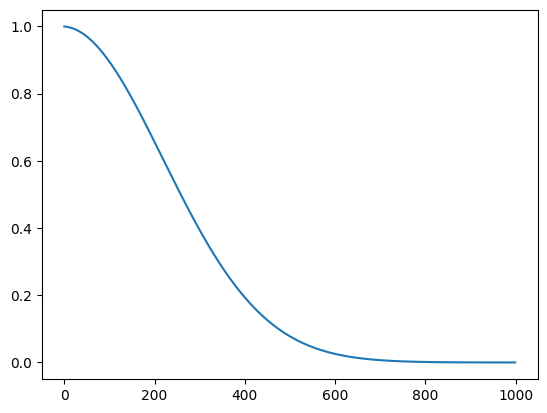

In [46]:
plt.plot(noise_scheduler.alphas_cumprod, label='alpha')

In [90]:
timesteps = torch.linspace(0, 998, 128).long().to(device)
noise = torch.randn_like(images.get('images'))
noise_by_timesteps = noise_scheduler.add_noise(images.get('images'), noise, timesteps)

In [48]:
def show_images_from_torch(x):
    x = x*0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_image = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_image = Image.fromarray(np.array(grid_image).astype(np.uint8))

    return grid_image

In [49]:
(noise_by_timesteps*0.5 + 0.5).shape

torch.Size([128, 3, 32, 32])

In [51]:
torchvision.utils.make_grid((noise_by_timesteps*0.5 + 0.5)).shape

torch.Size([3, 546, 274])

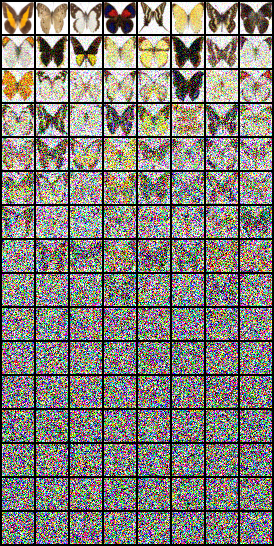

In [52]:
show_images_from_torch(noise_by_timesteps)

In [61]:
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'AttnDownBlock2D',
    ),
    up_block_types=(
        'AttnUpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    )  
)
model = model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [62]:
with torch.no_grad():
    predicted = model(noise_by_timesteps, timesteps)
    

In [63]:
predicted

UNet2DOutput(sample=tensor([[[[ 1.9762e-01,  1.8091e-01,  3.0840e-01,  ...,  1.4743e-01,
            1.7607e-01,  1.9796e-01],
          [ 2.0081e-01,  3.4210e-01,  5.8891e-01,  ...,  4.8077e-01,
            5.4493e-01,  3.9708e-01],
          [ 1.2594e-01,  1.0559e-01,  2.2189e-01,  ...,  1.4426e-01,
            3.1624e-01,  2.4902e-01],
          ...,
          [-3.9996e-01, -9.4781e-01, -1.2238e+00,  ..., -1.8156e-01,
            3.1535e-01, -2.5405e-01],
          [-1.7377e-01, -3.6723e-01, -6.4899e-01,  ..., -4.0237e-01,
           -4.0974e-02, -1.9122e-01],
          [-4.7617e-01, -4.1387e-01, -3.0075e-01,  ..., -3.1681e-01,
            3.2924e-02, -2.2871e-01]],

         [[ 1.1843e-01, -4.4078e-02, -1.2616e-02,  ...,  2.3009e-01,
            5.6593e-02,  9.8774e-02],
          [ 5.1347e-02,  7.6650e-02,  9.9575e-02,  ...,  2.5382e-01,
            1.1466e-01,  6.5748e-02],
          [ 1.3837e-02, -2.6484e-02, -2.2052e-02,  ..., -2.2862e-02,
           -3.3468e-02,  1.3721e-01],


In [82]:
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule='squaredcos_cap_v2',
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

losses = []

for epoch in range(10):
    for step, batch in enumerate(train_dataloader):
        images = batch.get('images').to(device)
        noise = torch.randn_like(images).to(images.device)
        batch_size = len(images)

        timesteps = torch.randint(
            0,
            noise_scheduler.num_train_timesteps,
            (batch_size,),
            device=images.device,
        )

        noisy_images = noise_scheduler.add_noise(
            images,
            noise,
            timesteps,
        )

        noise_predicted = model(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_predicted, noise)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()

    if (epoch+1) % 5 == 0:
        last_epoch_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f'[Epoch: {epoch+1}] | loss: {last_epoch_loss}')

c:\Users\USER\.conda\envs\nlp\lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


[Epoch: 5] | loss: 0.18721898458898067


KeyboardInterrupt: 

In [76]:
device='cuda' if torch.cuda.is_available() else 'cpu'

model_id='ceyda/ddpm-ema-butterflies-64'

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to(device)

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

c:\Users\USER\.conda\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--ceyda--ddpm-ema-butterflies-64. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/785 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\USER\.cache\huggingface\hub\models--ceyda--ddpm-ema-butterflies-64\snapshots\30ccb17200be50e024b6485e2fc2e337600866c9\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\USER\.cache\huggingface\hub\models--ceyda--ddpm-ema-butterflies-64\snapshots\30ccb17200be50e024b6485e2fc2e337600866c9\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


ValueError: Pipeline <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> expected {'unet', 'vae', 'scheduler', 'image_encoder', 'text_encoder', 'tokenizer', 'safety_checker', 'feature_extractor'}, but only {'unet', 'scheduler'} were passed.

In [66]:
dataset_id='RIW/butterfly_wm_100_1'
dataset=load_dataset(dataset_id, split='train')

image_size=32
batch_size=128

dataset.set_transform(transform)

README.md:   0%|          | 0.00/280 [00:00<?, ?B/s]

c:\Users\USER\.conda\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\datasets--RIW--butterfly_wm_100_1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/98.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/901 [00:00<?, ? examples/s]

In [67]:
train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    )

In [68]:
images = list(train_dataloader)[0]

In [80]:
timesteps = torch.linspace(0, 998, 128).long().to(device)
noise = torch.randn_like(images.get('images'))
noise_by_timesteps = noise_scheduler.add_noise(images.get('images'), noise, timesteps)

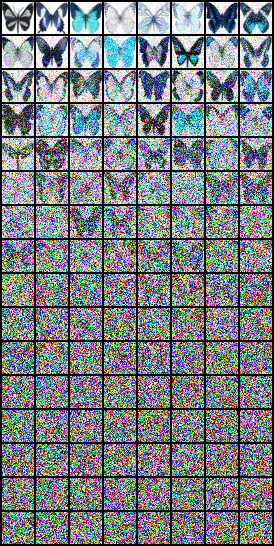

In [81]:
show_images_from_torch(noise_by_timesteps)

### Fine-tuning

#### Step1: model load

> ```python
> device = "cuda" if torch.cuda.is_available() else "cpu"
> 
> image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
> image_pipe.to(device)
> ```


#### Step2: dataset load

> ```python
> # 데이터 전처리 파이프라인 정의
> # 'huggan/smithsonian_butterflies_subset' 데이터셋 로드 (train split 사용)
> dataset = load_dataset('huggan/smithsonian_butterflies_subset', split='train')
> 
> preprocess = transforms.Compose(
>     [
>         transforms.Resize((image_size, image_size)),  # 이미지 크기를 (256, 256)으로 변경
>         transforms.RandomHorizontalFlip(),  # 무작위로 좌우 반전 (데이터 증강)
>         transforms.ToTensor(),  # 이미지를 텐서로 변환
>         transforms.Normalize([0.5], [0.5]),  # 이미지 정규화 (값 범위: -1 ~ 1)
>     ]
> )
>
> # 데이터셋의 이미지에 전처리 적용하는 함수 정의
> def transform(examples):
>     images = [preprocess(image.convert('RGB')) for image in examples['image']]  # 이미지를 RGB로 변환 후 전처리
>     return {'images': images}
> 
> # 데이터셋에 변환 함수 적용
> dataset.set_transform(transform)
> 
> # DataLoader 설정 (배치 크기, 무작위 섞기)
> train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
> ```

#### Step3: scheduler define

> ```python
> scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
> scheduler.set_timesteps(num_inference_steps=40)
> ```

#### Step4: fine-tuning

> ```python
> # 학습 하이퍼파라미터 설정
> num_epochs = 2  # @param: 에포크 수 설정
> lr = 1e-5  # @param: 학습률 설정
> grad_accumulation_steps = 2  # @param: 기울기 누적 스텝 설정
> 
> # 옵티마이저 설정 (AdamW)
> optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)
> 
> # 손실 값을 저장할 리스트 초기화
> losses = []
> 
> # 학습 루프
> for epoch in range(num_epochs):
>     for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):  # 배치마다 진행
>         clean_images = batch["images"].to(device)  # 배치의 이미지를 디바이스로 전송
> 
>         # 이미지에 추가할 노이즈 샘플링
>         noise = torch.randn(clean_images.shape).to(clean_images.device)
>         bs = clean_images.shape[0]  # 배치 크기 추출
> 
>         # 각 이미지에 대해 랜덤한 타임스텝 샘플링
>         timesteps = torch.randint(
>             0,
>             image_pipe.scheduler.num_train_timesteps,
>             (bs,),
>             device=clean_images.device,
>         ).long()
> 
>         # 타임스텝에 맞춰 노이즈를 이미지에 추가 (전방 확산 과정)
>         noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)
> 
>         # 모델 예측값 얻기 (노이즈 예측)
>         noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]
> 
>         # 예측된 노이즈와 실제 노이즈를 비교하여 손실 계산
>         loss = F.mse_loss(
>             noise_pred, noise
>         )  # 노이즈 예측 (eps)을 예측하고, 실제 노이즈와 비교
> 
>         # 손실 값을 나중에 플로팅하기 위해 저장
>         losses.append(loss.item())
> 
>         # 손실에 기반하여 모델 파라미터 업데이트
>         loss.backward()  # 역전파
> 
>         # 기울기 누적
>         if (step + 1) % grad_accumulation_steps == 0:  # 지정된 스텝마다 기울기 업데이트
>             optimizer.step()
>             optimizer.zero_grad()  # 기울기 초기화
> 
>     # 에포크마다 평균 손실 출력
>     print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")
>
> # 손실 곡선 시각화
> plt.plot(losses)
> ```

#### Step5: image generation

> ```python
> # 이미지를 생성하고 시각화하기
> x = torch.randn(8, 3, 256, 256).to(device)  # 배치 크기 8, 크기 256x256의 랜덤 이미지
> 
> # 타임스텝별로 이미지를 생성하는 루프
> for i, t in tqdm(enumerate(scheduler.timesteps)):  # 각 타임스텝마다 반복
> 
>     # 타임스텝에 맞게 모델 입력값 스케일링
>     model_input = scheduler.scale_model_input(x, t)
> 
>     # 모델 예측 (그래디언트 비활성화)
>     with torch.no_grad():
>         noise_pred = image_pipe.unet(model_input, t)['sample']
> 
>     # 예측된 노이즈를 사용하여 샘플 업데이트
>     x = scheduler.step(noise_pred, t, x).prev_sample
> 
> # 배치의 이미지를 그리드 형태로 변환
> grid = torchvision.utils.make_grid(x, nrow=4)
> 
> # 이미지를 출력 ([-1, 1] 범위를 [0, 1] 범위로 변환하여 출력)
> plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)
> ```

In [ ]:
!pip install open-clip-torch

In [96]:
model_id = 'google/ddpm-celebahq-256'
image_pipe = DDPMPipeline.from_pretrained(model_id)
image_pipe.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\USER\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\USER\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [93]:
images = image_pipe()
images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [94]:
scheduler = DDIMScheduler.from_pretrained(model_id)
scheduler.set_timestpes(num_inference_steps=40)

AttributeError: 'DDIMScheduler' object has no attribute 'set_timestpes'

In [95]:
x = torch.randn(4, 3, 256, 256)

for i, timestep in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, timestep)

    with torch.no_grad():
        noise_predicted = image_pipe.unet(model_input, timestep)['sample']

    scheduler_output = scheduler.stemp(noise_predicted, timestep, x)

    x = scheduler_output.prev_sample

    if i%1 == 0 or i == len(scheduler.timesteps):
        fig, axes = plt.subplot(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axes[0].imshow(grid.cpu().clip(-1, 1)*0.5 + 0.5)
        axes[0].set_title(f'Current (step {i})')

        pred_x0 = scheduler_output.pred_original_sample
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axes[1].imshow(grid.cpu().clip(-1, 1)*0.5 + 0.5)
        axes[1].set_title(f'Predicted denoised images (step {i})')

        plt.show()

0it [00:00, ?it/s]

AttributeError: 'DDIMScheduler' object has no attribute 'stemp'

In [ ]:
dataset_id = 'RIW/butterfly_wm_100_1'
dataset = load_dataset(dataset_id, split='train')

image_size = 64
batch_size = 8

_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def transform(sample):
    images = [_transform(image.convert('RGB')) for image in sample['image']]
    
    return {'images': images}

dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

In [ ]:
gradient_accumulation_steps=4
optimizer = torch.optim.AdamW(image_pipe.unet.parameter(), lr=1e-5)

losses=[]
for epoch in range(1, 6):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        images = batch.get('images').to(device)
        noise = torch.randn_like(images).to(images.device)

        timesteps = torch.randint(
            0, image_pipe.scheduler.num_train_timesteps,
            (batch_size,),
            device=images.device,
        ).long()
    
        noisy_images = image_pipe.scheduler.add_noise(images, noise, timesteps)
        noise_predicted = image_pipe.unet(noisy_images, timestpes, return_dict=False)[0]

        loss = F.mse_loss(noise_predicted, noisy_images)
        losses.append(loss.item())

        if (step+1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    average_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'[Epoch: {epoch} | average loss: {average_loss}]')

plt.plot(losses)

### Stable Diffusion

#### img2text

> ```python
> # 모델 로드
> model_id = 'stabilityai/stable-diffusion-2-1-base'  # 모델 ID 설정
> pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)  # 모델 로드 및 디바이스로 이동
> 
> # 랜덤 시드 고정 (반복 가능한 결과를 위해)
> generator = torch.Generator(device=device).manual_seed(42)
> 
> # 파이프라인 실행 (이미지 생성)
> pipe_output = pipe(
>     prompt="Palette knife painting of an autumn cityscape",  # 생성할 이미지의 프롬프트
>     negative_prompt="Oversaturated, blurry, low quality",  # 생성하지 않을 이미지의 프롬프트
>     height=480,  # 생성할 이미지의 높이
>     width=640,  # 생성할 이미지의 너비
>     guidance_scale=8,  # 프롬프트를 따르는 강도 (높을수록 더 강하게 따름)
>     num_inference_steps=35,  # 생성 과정의 스텝 수 (더 많을수록 더 정교한 이미지)
>     generator=generator,  # 고정된 랜덤 시드 사용
> )
> 
> ```

In [ ]:
model_id='stabilityai/stable-diffusion-2-1-base'
pipe=StableDiffusionPipeline.from_pretrained()

#### img2img

> ```python
> # Img2Img
> # Img2Img pipeline 로드
> model_id = 'stabilityai/stable-diffusion-2-1-base'
> 
> img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)
> # 이미지 변환 파이프라인 실행 (img2img)
> result_image = img2img_pipe(
>     prompt='An oil painting of a man on a bench',  # 생성할 이미지의 프롬프트
>     image=init_image,  # 초기 이미지 (변환할 이미지)
>     strength=0.6,  # 변환 강도 (0은 변경 없음, 1.0은 최대 강도)
> ).images[0]  # 첫 번째 결과 이미지를 추출
> 
>
> # In-painting
> # 인페인팅 파이프라인 로드 (적절한 인페인팅 모델이 필요)
> pipe = StableDiffusionInpaintPipeline.from_pretrained('runwayml/stable-diffusion-inpainting')  # 모델 로드
> pipe = pipe.to(device)  # 디바이스로 파이프라인 이동
>
> # 변환할 이미지와 마스크를 사용하여 인페인팅 수행
> prompt = 'A small robot, high resolution, sitting on a park bench'  # 결과 이미지에 대한 프롬프트
> image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]  # 초기 이미지와 마스크를 사용하여 인페인팅
> ```

# WebUI

Stable Diffusion과 같은 text-image 생성 모델을 보다 쉽게 사용할 수 있도록 함. <br>
WebUI를 통해 코드 작성 없이도 다양한 이미지 생성 설정을 조정할 수 있음. <br>
Automatic1111 프로젝트가 대표적. <br>


<br>

설치 링크: https://colab.research.google.com/github/TheLastBen/fast-stable-diffusion/blob/main/fast_stable_diffusion_AUTOMATIC1111.ipynb#scrollTo=PjzwxTkPSPHf

## Models

모델의 ckpt나 safetensor를 받아 모델 추가 가능 <br>
**sd/StableDiffusion/stable-diffusion-webui/models/Stable-diffusion** 아래에 모델 복사 후 사용 <br>
모델 추가 후 새로고침. <br>

<br>

모델 다운 사이트: <br>
huggingface: https://huggingface.co/models <br>
civitai: https://civitai.com/models <br>

## Extensions

**PreSet Utils**: 이미지 생성 설정들의 프리셋을 만들어 사용 가능 <br>
url: https://github.com/Gerschel/sd_web_ui_preset_utils

<br>

**Stable Diffusion WebUI Aspect Ratio selector**: 이미지 비율 자동 설정 버튼 <br>
url: https://github.com/alemelis/sd-webui-ar.git

<br>

**Stable Diffusion Dynamic Thresholding**: CFG scale이 올라갈수록 생기는 색 변화를 제거 <br>
url: https://github.com/mcmonkeyprojects/sd-dynamic-thresholding

<br>

**tagcomplete**: prompt 태그 자동 완성 <br>
url: https://github.com/DominikDoom/a1111-sd-webui-tagcomplete

<br>

**webui-wd14-tagger**: 사진을 분석하여 prompt 태그 자동 생성 <br>
url: https://github.com/picobyte/stable-diffusion-webui-wd14-tagger

<br>

**sd-webui-controlnet**: 포즈(뼈대)나 이미지를 제시하여 원하는 이미지 생성을 가능케 함<br>
url: https://github.com/Mikubill/sd-webui-controlnet <br>

<br>

**openpose-editor**: 컨트롤넷에 사용할 뼈대를 직접 만들수 있도록 함 <br>
url: https://github.com/fkunn1326/openpose-editor

<br>

**posex**: 3D 오픈포즈 에디터 <br>
url: https://github.com/hnmr293/posex

## Prompt

<font style="font-size:20px"> prompt </font>

텍스트를 입력하여 원하는 이미지 생성이 되도록 입력. <br>
아래의 두 가지로 구분. <br>

positive prompt: 모델에서 이미지 생성 시 반영되길 원하는 내용. <br>
negative prompt: 모델에서 이미지 생성 시 반영되지 않길 원하는 내용. <br>

다만, 위의 내용을 100% 반영하지 않기에, 원하는 이미지를 얻기까지 많은 노력 요구. <br>

<br>


<font style="font-size:20px"> Prompt Weight </font>

프롬프트에는 가중치 부여 가능 <br>

| |(keyword)|((keyword))|[keyword]|[[keyword]]|
|-|---------|-----------|---------|-----------|
|weight|1.1|1.2|0.9|0.8|

()로 한 번 묶을 때마다 0.1 증가. <br>
[]로 한 번 묶을 때마다 0.1 감소. <br>
0.1 ~ 1.4의 값 할당 추천. <br>

<br>

<font style="font-size:20px"> Samplnig Method </font>

sampling method: 어떤 샘플링 방식으로 이미지를 생성할 것인지 결정. <br>
방식에 따라서 이미지에 미묘한 차이가 있고, 생성 속도도 다름. <br>
주로 Eular a, DPM++ 2M Karras, DPM++ SDE Karras 등이 사용. <br>

<br>

<font style="font-size:20px"> Samplnig Step </font>

step이 높을수록 고품질의 이미지 생성 가능. <br>
보통 20~30 사용. <br>
수치가 높으면 더 많은 생성 시간 소요. <br>

<br>

<font style="font-size:20px"> Upscaler </font>

upscaling 방식 지정. <br>
2D 이미지는 주로 R-ESRGAN 4x+ Anime6B, Latent 등 사용 <br>
실사 이미지는 주로 R-ESRGAN 사용 <br>

<br>

<font style="font-size:20px"> Denoising strength </font>

값이 높으면 기존 그림에서 더 많은 변화를, 낮으면 기존 그림과 유사하도록 생성. <br>

<br>

<font style="font-size:20px"> Batch count </font>

이미지를 몇 장 생성할 지 결정. <br>

<br>

<font style="font-size:20px"> Batch size </font>

하나의배치에 들어갈 이미지 수 결정. <br>

<br>

<font style="font-size:20px"> CFG Scale </font>

프롬프트의 영향력을 설정. <br>
수치가 높으면 프롬프트에 적힌 대로 생성될 확률이 높아짐 <br>
수치가 낮으면 AI의 자유도가 올라감. <br>
너무 낮으면 이미지가 흐려질 수 있고, 너무 높으면 오히려 이미지가 정상적이 않을 수 있기 때문에 적정 수준에서 값 설정. <br>

## img2img

clip 분석 이후 deepbooru를 통해 positive prompt 획득 가능. <br>

<br>

<font style="font-size:20px"> infaint </font>

이미지를 수정하여 새로운 이미지를 만드는 방법. <br>
수정할 부분을 칠한 후 generate 클릭. <br>


## Lora

Lora는 기존 학습 모델에 새로운 이미지를 학습시킨 모델 파일. <br>
기존 학습 모델에 본인이 적용하고 싶은 스타일을 추가로 학습시킨 파일로, <br>
프롬프트에 적용시켜 좀 더 원하는 이미지를 생성할 수 있도록 함. <br>
Lora는 본인이 직접 만들 수도 있고, 사이트에서 다운로드하여 이용 가능. <br>

ex)
게임을 제작 시 주인공 캐릭터의 로라를 만들어 여러 주인공 이미지 생성. <br>

<br>

**sd/StableDiffusion/stable-diffusion-webui/models/Lora**에 추가하여 사용 <br>


## VAE

이미지를 보정해주는 역할. <br>
만약 생성된 이미지가 흐리거나 퀄리티를 높이고 싶다면 VAE 적용. <br>
크게 2D 애니메이션 풍과 실사 이미지 중에서 선택.

<br>

**sd/StableDiffusion/stable-diffusion-webui/models/VAE**에 추가하여 사용 <br>

<br>

**Settings/Stable Diffusion/VAE/SD VAE**에서 모델 선택
 

## Embedding

임베딩은 이미 학습된 프롬프트를 한번에 적용해주는 파일. <br>
positive prompt와 negative prompt에 모두 사용이 가능. <br>

<br>

**sd/StableDiffusion/stable-diffusion-webui/embeddings**에 추가하여 사용 <br>

## ControlNet

이미지 생성 컨트롤을 가능하게 해 주는 기술. <br>
이미지를 생성할 때 외부 입력 신호를 추가로 받아, 원하는 방향으로 이미지의 스타일이나 구성을 조절할 수 있도록 도움. <br>

<br>

**sd/StableDiffusion/stable-diffusion-webui/models/ControlNet**에 추가하여 사용